In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import torch
import torch.optim as optim

import simple_pinn
import cv_mesh
import cv_solver

# for dev purposes, reload these modules each time this cell is run
import importlib
importlib.reload(simple_pinn)
importlib.reload(cv_mesh)
importlib.reload(cv_solver)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 

In [2]:
t_domain = [0.0, 1.0]
x_domain = [-1.0, 1.0]
Nt = 100
Nx = 300
mesh = cv_mesh.CVMesh(t_domain, x_domain, Nt, Nx, None, quad_pts=(8, 8))
mesh.to(DEVICE)


def burgers_state_vec_to_fluxes(state_vec, eos):
    u = state_vec[..., 0]
    F_t = u.unsqueeze(-1)
    F_x = (0.5 * u * u).unsqueeze(-1)
    return F_t, F_x


def burgers_state_vec_to_entropy_fluxes(state_vec, eos):
    u = state_vec[..., 0]
    F_t = (u * u).unsqueeze(-1)
    F_x = ((2.0 / 3.0) * u * u * u).unsqueeze(-1)
    return F_t, F_x


def burgers_ic_state_vec_evaluation(eval_points, eos):
    return torch.where(eval_points[..., 1] < 0, 0.0, 1.0).unsqueeze(-1)


def burgers_analytic_soln(eval_points, eos, visc=1.0e-5):
    x = eval_points[..., 1]
    t = eval_points[..., 0]
    # left side of the solution
    u = torch.where(x < 0, 0.0, 1.0)
    # right side of the solution, *ahead* of the shock front
    u = torch.where((x - t) > 0, 1.0, u)
    # right side of the solution, behind the shock front, i.e., the rarefaction fan
    u = torch.where(torch.logical_and(x > 0, x - t < 0), x / t, u)
    return u.unsqueeze(-1)


model = simple_pinn.DirichletPINN(
    2, [32, 32, 32], 1, mesh, burgers_ic_state_vec_evaluation, None
).to(DEVICE)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

cv_solver = cv_solver.CVSolver(
    mesh,
    model,
    burgers_state_vec_to_fluxes,
    burgers_state_vec_to_entropy_fluxes,
    burgers_ic_state_vec_evaluation,
    burgers_analytic_soln,
    None,
)

DirichletPINN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1-2): 2 x Linear(in_features=32, out_features=32, bias=True)
  )
  (head): Linear(in_features=32, out_features=1, bias=True)
  (activation): ReLU()
)


In [3]:
n_epochs = 20_000
for epoch in range(n_epochs):
    cv_pde_loss, cv_entropy_loss = cv_solver.forward()
    optimizer.zero_grad()
    loss = cv_pde_loss + 0.1 * cv_entropy_loss
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(
            f"Epoch {epoch}: cv_pde_loss={cv_pde_loss.item():.3e}, cv_entropy_loss={cv_entropy_loss.item():.3e}"
        )

Epoch 0: cv_pde_loss=8.429e-03, cv_entropy_loss=4.444e-03
Epoch 100: cv_pde_loss=5.844e-03, cv_entropy_loss=4.200e-03
Epoch 200: cv_pde_loss=2.576e-03, cv_entropy_loss=1.934e-03
Epoch 300: cv_pde_loss=1.158e-03, cv_entropy_loss=1.390e-04
Epoch 400: cv_pde_loss=8.664e-04, cv_entropy_loss=7.592e-05
Epoch 500: cv_pde_loss=7.374e-04, cv_entropy_loss=6.096e-05
Epoch 600: cv_pde_loss=6.709e-04, cv_entropy_loss=5.527e-05
Epoch 700: cv_pde_loss=6.171e-04, cv_entropy_loss=5.075e-05
Epoch 800: cv_pde_loss=5.668e-04, cv_entropy_loss=4.711e-05
Epoch 900: cv_pde_loss=5.194e-04, cv_entropy_loss=4.450e-05
Epoch 1000: cv_pde_loss=4.758e-04, cv_entropy_loss=4.243e-05
Epoch 1100: cv_pde_loss=4.355e-04, cv_entropy_loss=4.068e-05
Epoch 1200: cv_pde_loss=3.981e-04, cv_entropy_loss=3.904e-05
Epoch 1300: cv_pde_loss=3.627e-04, cv_entropy_loss=3.712e-05
Epoch 1400: cv_pde_loss=3.210e-04, cv_entropy_loss=3.417e-05
Epoch 1500: cv_pde_loss=2.842e-04, cv_entropy_loss=2.994e-05
Epoch 1600: cv_pde_loss=2.554e-04, c

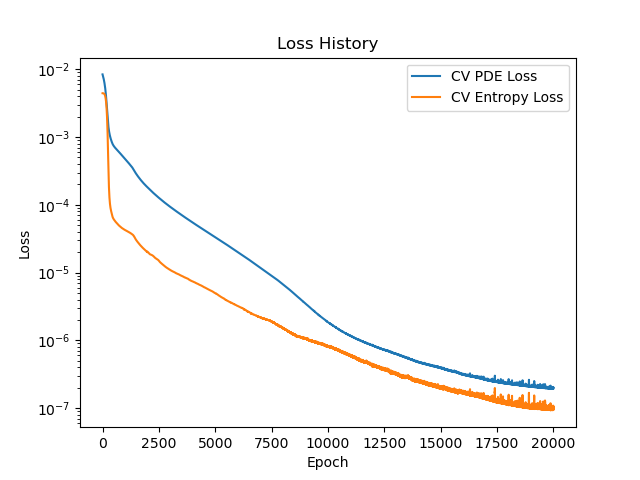

In [7]:
cv_solver.plot_loss_history()

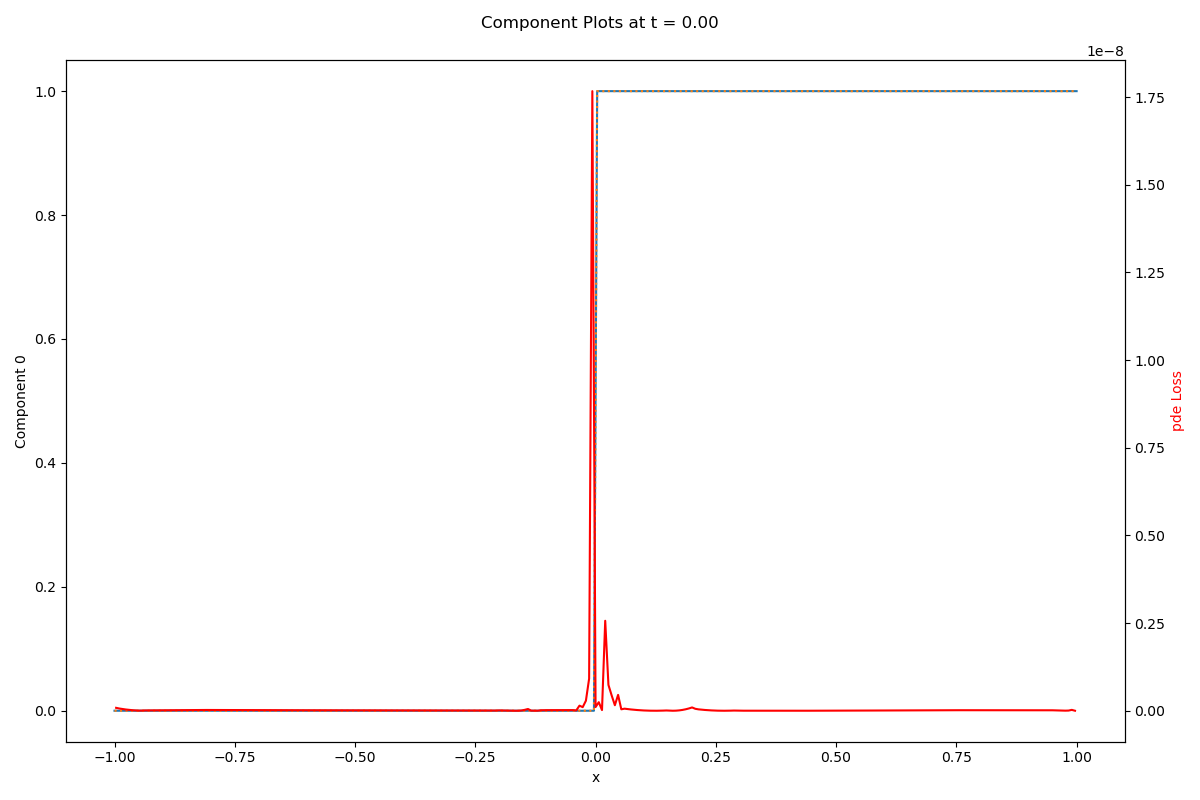

In [5]:
cv_solver.plot_components(0, with_ics=True, loss_to_plot="pde")

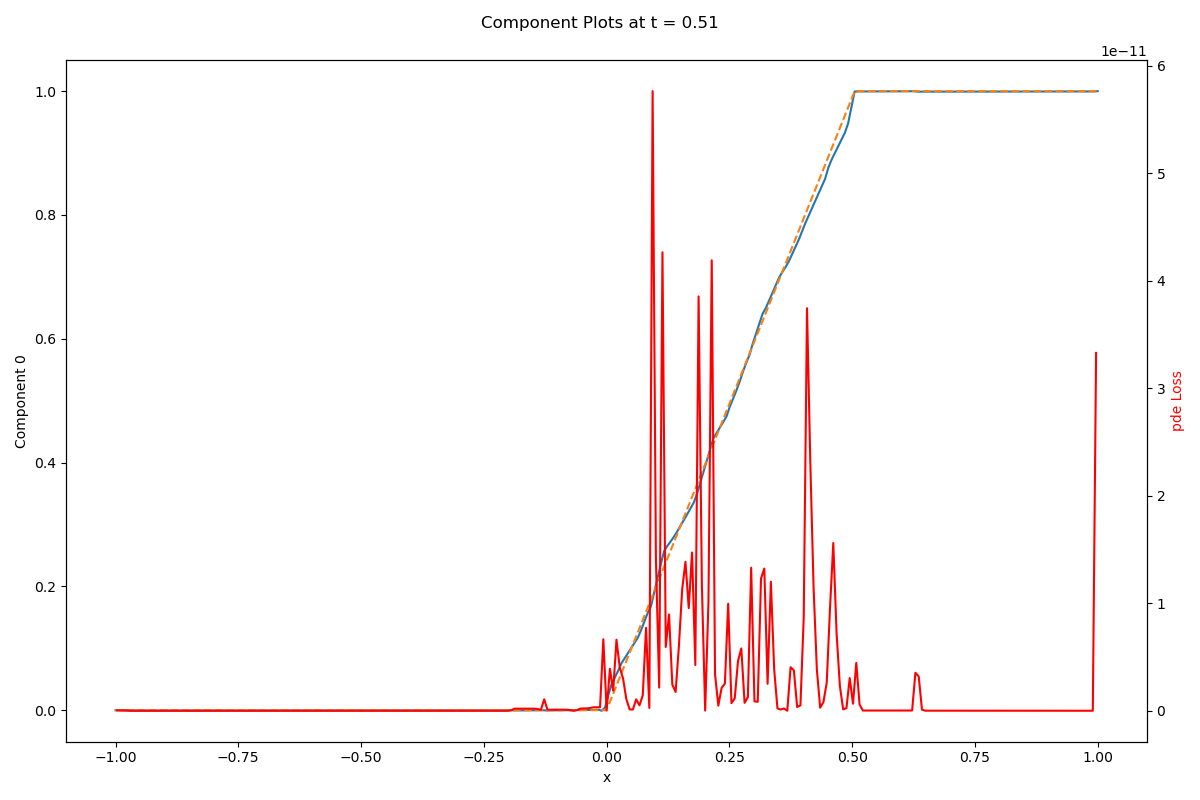

In [6]:
cv_solver.plot_components(50, with_analytic_soln=True, loss_to_plot="pde")